In [1]:
from pathlib import Path
import pickle as pkl
import itertools as it

import pandas as pd

import sys; sys.path.append('..')
import config as cfg

%load_ext autoreload
%autoreload 2

In [2]:
# if True rerun DE analysis and overwrite existing results 
# if False look for existing results and don't rerun DE analysis
# (the latter makes the notebook run much faster)
RUN_DE_ANALYSIS = False

In [3]:
cfg.de_input_dir.mkdir(parents=True, exist_ok=True)
cfg.de_output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# load gene expression counts data
all_counts_df = pd.read_csv(cfg.processed_counts_file, sep='\t', index_col=0)
print(all_counts_df.shape)
all_counts_df.iloc[:5, :5]

(10530, 60498)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16
sample_id,,,,,
TCGA-02-0047-01,2132,1,552,387,269
TCGA-02-0055-01,2590,742,2110,493,452
TCGA-02-2483-01,4438,1,2230,735,653
TCGA-02-2485-01,4615,4,1022,629,672
TCGA-04-1331-01,6159,10,2752,1173,1091


In [5]:
# load park et al. initial analysis results here
park_info_df = pd.read_csv(
    cfg.park_info_file, sep='\t'
)

print(park_info_df.shape)
park_info_df.head()

(308148, 7)


,sample_id,positive_prob,identifier,mutation_status,copy_status,status,class
0,TCGA-4E-A92E-01,1.558183e-08,ACVR1_UCEC,0,0.0,none,class 1
1,TCGA-A5-A0GB-01,2.734236e-237,ACVR1_UCEC,1,0.0,one,class 1
2,TCGA-A5-A0GJ-01,0.000000e+00,ACVR1_UCEC,0,0.0,none,class 1
3,TCGA-A5-A0GM-01,0.000000e+00,ACVR1_UCEC,0,0.0,none,class 1
4,TCGA-A5-A0GW-01,0.000000e+00,ACVR1_UCEC,0,0.0,none,class 1


In [6]:
# for now, we'll just run these with a few hand-picked examples
# in the future we should run for all examples + do some kind of synthesis
class_1_id = 'NF2_KIRP'
class_2_id = 'PTEN_UCEC'
class_3_id = 'KRAS_COADREAD'
class_4_id = 'TP53_BRCA'

class_ids = [class_1_id, class_2_id, class_3_id, class_4_id]

In [7]:
exp_output = str(cfg.de_input_dir / '{}_{}_{}_counts.tsv')
info_output = str(cfg.de_input_dir / '{}_{}_{}_info.tsv')

for class_id in class_ids:
    gene, cancer_type = class_id.split('_')
    for status_1, status_2 in it.combinations(
        ['none', 'one', 'both'], 2
    ):
        
        print(class_id, status_1, status_2)
        
        # TODO figure out where the duplicates come from
        info_df = park_info_df[
            ((park_info_df.identifier == class_id) &
             (park_info_df.status.isin([status_1, status_2])))
        ].drop_duplicates()
        info_df.set_index('sample_id', inplace=True)
        info_df.rename(columns={'status': 'group'}, inplace=True)
        
        samples = (
            info_df.index.intersection(all_counts_df.index)
        )
        exp_df = all_counts_df.loc[samples, :]
        info_df = info_df.loc[samples, :]
        
        exp_df.to_csv(
            exp_output.format(class_id, status_1, status_2),
            sep='\t'
        )
        info_df.group.to_csv(
            info_output.format(class_id, status_1, status_2),
            sep='\t'
         )
    
info_df.head()

NF2_KIRP none one
NF2_KIRP none both
NF2_KIRP one both
PTEN_UCEC none one
PTEN_UCEC none both
PTEN_UCEC one both
KRAS_COADREAD none one
KRAS_COADREAD none both
KRAS_COADREAD one both
TP53_BRCA none one
TP53_BRCA none both
TP53_BRCA one both


,positive_prob,identifier,mutation_status,copy_status,group,class
sample_id,,,,,,
TCGA-3C-AALJ-01,0.500288,TP53_BRCA,0,1.0,one,class 4
TCGA-4H-AAAK-01,0.242001,TP53_BRCA,0,1.0,one,class 4
TCGA-A1-A0SD-01,0.125136,TP53_BRCA,0,1.0,one,class 4
TCGA-A1-A0SE-01,0.145589,TP53_BRCA,0,1.0,one,class 4
TCGA-A1-A0SI-01,0.727915,TP53_BRCA,1,1.0,both,class 4


In [8]:
base_dir = str(cfg.de_base_dir)
input_dir = str(cfg.de_input_dir)
output_dir = str(cfg.de_output_dir)

In [9]:
%load_ext rpy2.ipython

In [10]:
%%R -i RUN_DE_ANALYSIS -i base_dir -i input_dir -i output_dir 

if (RUN_DE_ANALYSIS) {
    source(paste0(base_dir, '/de_analysis.R'))

    # this stuff probably shouldn't be hardcoded, but fine for now
    identifiers <- c(
        'NF2_KIRP',
        'PTEN_UCEC',
        'KRAS_COADREAD',
        'TP53_BRCA'
    )

    status_combs <- list()
    status_combs[[1]] <- c('none', 'one')
    status_combs[[2]] <- c('none', 'both')
    status_combs[[3]] <- c('one', 'both')

    for (i in 1:length(identifiers)) {
        identifier <- identifiers[i]
        for (j in 1:length(status_combs)) {
            status_1 <- status_combs[[j]][1]
            status_2 <- status_combs[[j]][2]
            counts_file <- paste(input_dir,
                                 '/',
                                 identifier,
                                 '_',
                                 status_1,
                                 '_',
                                 status_2,
                                 '_counts.tsv',
                                 sep='')
            info_file <- paste(input_dir,
                               '/',
                               identifier,
                               '_',
                               status_1,
                               '_',
                               status_2,
                               '_info.tsv',
                               sep='')
            print(counts_file)
            print(info_file)
            get_DE_stats_DESeq(info_file,
                               counts_file,
                               paste(identifier, '_', status_1, '_', status_2,
                                     sep=''),
                               output_dir)

        }
    }
} else {
    print('Skipping DE analysis, will use existing results files')
}

[1] "Skipping DE analysis, will use existing results files"


In [30]:
identifier = 'NF2_KIRP'
# adjusted p-value threshold
alpha = 0.05

none_one_de_results = pd.read_csv(
    cfg.de_output_dir / 'DE_stats_{}_none_one.txt'.format(identifier), sep='\t'
)
print(none_one_de_results.shape)
none_one_de_results.head()

(60498, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000003.14,2994.453304,0.293759,0.080615,3.643978,0.000268,0.003980
ENSG00000000005.5,12.776880,0.861227,0.349031,2.467479,0.013607,0.081531
ENSG00000000419.12,1058.682467,0.066241,0.059720,1.109202,0.267343,0.688138
ENSG00000000457.13,568.464789,-0.065880,0.071727,-0.918483,0.358366,0.828795
ENSG00000000460.16,187.434862,0.362222,0.078386,4.621025,0.000004,0.000129


In [31]:
one_both_de_results = pd.read_csv(
    cfg.de_output_dir / 'DE_stats_{}_one_both.txt'.format(identifier), sep='\t'
)
print(one_both_de_results.shape)
one_both_de_results.head()

(60498, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000003.14,3623.785104,0.281731,0.225862,1.247360,0.212265,1.000000
ENSG00000000005.5,19.048239,1.857813,0.902666,2.058140,0.039577,0.748831
ENSG00000000419.12,1162.729843,-0.027150,0.161068,-0.168559,0.866143,1.000000
ENSG00000000457.13,575.203730,0.052974,0.221812,0.238824,0.811242,1.000000
ENSG00000000460.16,241.519432,-0.044014,0.274534,-0.160322,0.872628,1.000000


In [32]:
none_both_de_results = pd.read_csv(
    cfg.de_output_dir / 'DE_stats_{}_none_both.txt'.format(identifier), sep='\t'
)
print(none_both_de_results.shape)
none_both_de_results.head()

(60498, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000003.14,2839.933543,-0.010657,0.176841,-0.060263,0.951946,0.999650
ENSG00000000005.5,10.707803,1.003410,0.800737,1.253109,0.210166,0.822603
ENSG00000000419.12,1040.781433,-0.091990,0.135737,-0.677710,0.497956,0.999650
ENSG00000000457.13,565.592256,0.123091,0.150591,0.817387,0.413707,0.999650
ENSG00000000460.16,177.832014,-0.409771,0.163123,-2.512043,0.012003,0.187333


In [33]:
none_one_de_count = (
    (none_one_de_results.padj < alpha).sum()
)
one_both_de_count = (
    (one_both_de_results.padj < alpha).sum()
)
none_both_de_count = (
    (none_both_de_results.padj < alpha).sum()
)

print('DE genes for {} none vs. one:'.format(identifier), none_one_de_count)
print('DE genes for {} one vs. both:'.format(identifier), one_both_de_count)
print('DE genes for {} none vs. both:'.format(identifier), none_both_de_count)

DE genes for NF2_KIRP none vs. one: 7041
DE genes for NF2_KIRP one vs. both: 155
DE genes for NF2_KIRP none vs. both: 1264


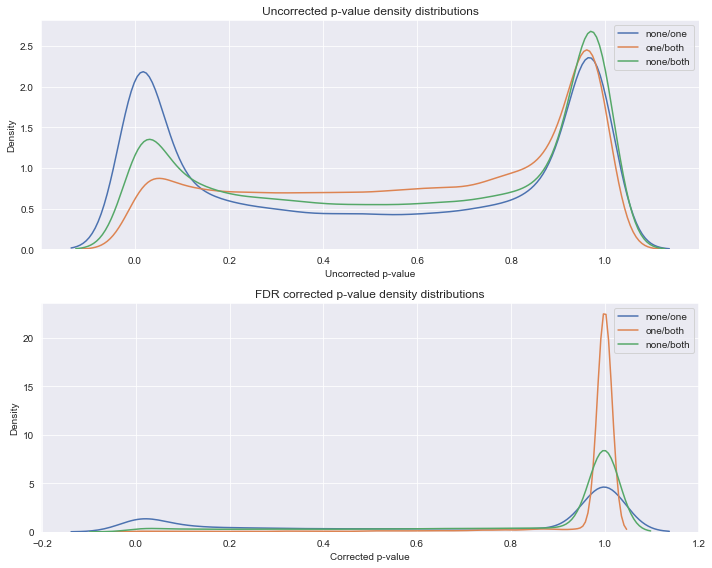

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set({'figure.figsize': (10, 8)})
fig, axarr = plt.subplots(2, 1)

sns.kdeplot(data=none_one_de_results.pvalue, label='none/one', ax=axarr[0])
sns.kdeplot(data=one_both_de_results.pvalue, label='one/both', ax=axarr[0])
sns.kdeplot(data=none_both_de_results.pvalue, label='none/both', ax=axarr[0])
axarr[0].set_title('Uncorrected p-value density distributions')
axarr[0].set_xlabel('Uncorrected p-value')
axarr[0].legend()

sns.kdeplot(data=none_one_de_results.padj, label='none/one', ax=axarr[1])
sns.kdeplot(data=one_both_de_results.padj, label='one/both', ax=axarr[1])
sns.kdeplot(data=none_both_de_results.padj, label='none/both', ax=axarr[1])
axarr[1].set_title('FDR corrected p-value density distributions')
axarr[1].set_xlabel('Corrected p-value')
axarr[1].legend()

plt.tight_layout()